In [283]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from numpy import array

## Step 0. Loading dataset

In [284]:
tesla_stocks = pd.read_csv('AdidasAG10Years.csv')


In [285]:
tesla_stocks.head()

,date,close,volume,open,high,low
0,16:00,104.760,"57,787",NaN,105.5700,104.5200
1,2017/12/01,104.595,79476.0000,104.25,104.9999,104.0000
2,2017/11/30,104.440,54341.0000,105.35,105.4840,104.2500
3,2017/11/29,104.920,106076.0000,107.21,107.3500,104.9200
4,2017/11/28,106.285,62220.0000,106.65,106.6500,105.9754


In [286]:
data_to_use = tesla_stocks['close'].values
data_to_use = np.flipud(data_to_use)

In [287]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 2522


## Step 1. Data preprocessing

#### Step 1.1 Scaling data mit Standart-Scaler

In [288]:
scaler = StandardScaler() # mapped alle Werte auf Wert:100 aufgrund von eventuell sehr hohen Werten -> squard error

#### Data vor der Skalierung

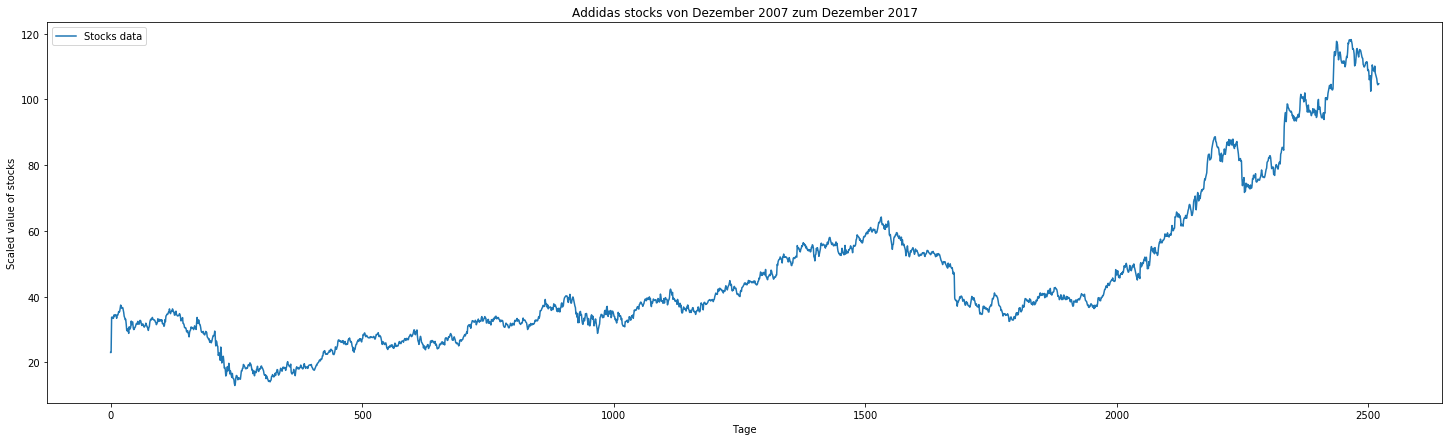

In [289]:
plt.figure(figsize=(25,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Addidas stocks von Dezember 2007 zum Dezember 2017')
plt.xlabel('Tage')
plt.ylabel('Scaled value of stocks')
plt.plot(data_to_use, label='Stocks data')
plt.legend()
plt.show()

In [290]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

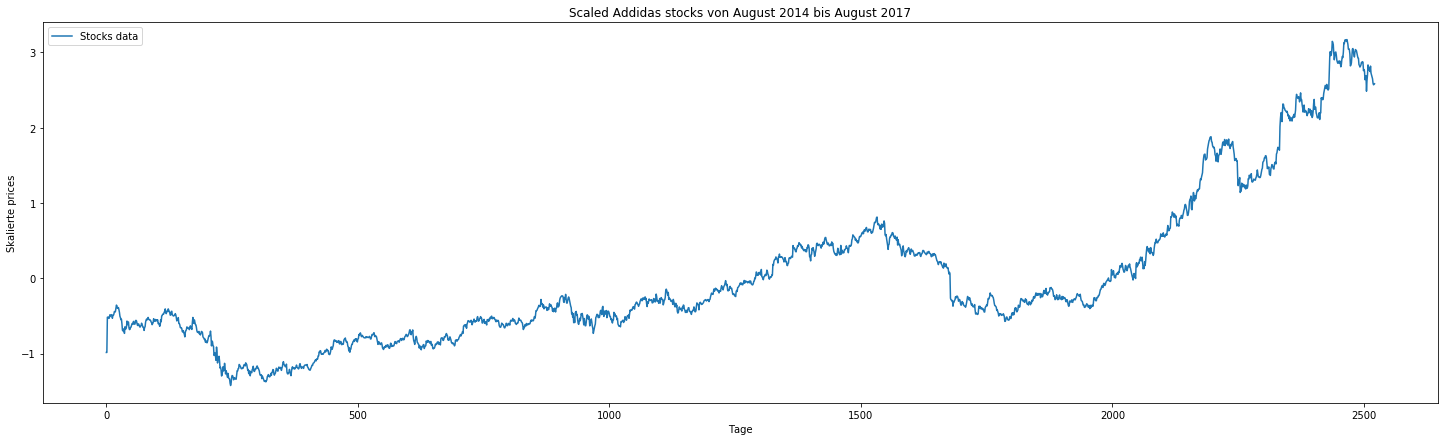

In [291]:
plt.figure(figsize=(25,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled Addidas stocks von August 2014 bis August 2017')
plt.xlabel('Tage')
plt.ylabel('Skalierte prices')
plt.plot(scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

In [292]:
batch_size = 7

###### windows data <br>
values 1-7 in einem window <br >
der 7. value wird zusätzlich in eben y gespeichert (=Label)

In [293]:
def window_data(data, window_size): #Taktik: speichere eine Liste von Werten der Datensätze von x bis x+ windowssize, danach speichere eine Liste von Werten der Datensätze von x+1 bis x+1+windowssize, damit man
                                    #praktisch immer nach 1 Windows eine Prediction machen kann
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1: #heißt eigentlich nach 7 Tagen = eine Prediction
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#### Step 1.2 Windowing the dataset

In [294]:
X, y = window_data(scaled_dataset, 7) #mn

#### Step 1.3 Creating Training and Testing sets
trainingsdaten: 0-700 <br>
testDaten 700-X

In [295]:
X_train  = np.array(X[:700])
y_train = np.array(y[:700])

X_test = np.array(X[700:])
y_test = np.array(y[700:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 7, 1)
y_train size: (700, 1)
X_test size: (1815, 7, 1)
y_test size: (1815, 1)


## Step 2. RNN - LSTM - Netzwerk erstellen

In [296]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        print(y_batch.shape, " || ")
        
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 1) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

RuntimeError: Attempted to use a closed Session.

#### Erstellung einer Zelle (komplettes Hiddenlayer)

In [ ]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8):
    
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        
    cell = tf.contrib.rnn.MultiRNNCell([layer]*number_of_layers) # multi-RNN stacked Basic Cell übereinander: basiccell1 -> basiccell2 -> bc3 -> ... -> output
    
    init_state = cell.zero_state(batch_size, tf.float32) #zero_state -> alle values to 0
    print(type(init_state),"n",init_state)
    return cell, init_state

#### Hdden Layer Backend

In [ ]:
def output_layer(lstm_output, in_size, out_size):
    print("__n", lstm_output,"n__")
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    
    output = tf.matmul(x, weights) + bias
    return output

###### gradient clipping  <br>
gradienten clipping = man beschränkt den exploding gradient auf eine max Zahl, sodass er nicht über diese max Zahl (Limit) gehen kann <br>
clipping hilft gegen exploding gradient, siehe standford folie 11: 46, code ist fast der selbe  <br>
eigentlich nur bei rekurrenten neuronalen Netzen -> <b> lstm gegen vanishing and clipping gegen exploding <b>

In [ ]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))]) #mse
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    #Cliping the gradient loss
    
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    return loss, train_optimizer

#### RNN - Object: <br/> <br/> Layer=1, hidden_layer_size=512, learning_rate=0.001, dropout=80%, window size=7, batch_size=7, 

In [ ]:
class StockPredictionRNN(object):
    
    def __init__(self, learning_rate=0.001, batch_size=7, hidden_layer_size=512, number_of_layers=1, 
                 dropout=True, dropout_rate=0.8, number_of_classes=1, gradient_clip_margin=4, window_size=7):
    
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)

        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)

        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes) # ....?

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)

In [ ]:
tf.reset_default_graph()
model = StockPredictionRNN(batch_size=batch_size)

## Step 3. Netzwerk trainieren

In [ ]:
session =  tf.Session()

In [ ]:
session.run(tf.global_variables_initializer())

In [ ]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 1) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

In [ ]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j])

In [ ]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [ ]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [ ]:
test_results = []
for i in range(2500): #eig749
    if i >= 701:
        test_results.append(tests_new[i-701])
        
    else:
        test_results.append(None)

## Step 4. Plotting predictions from the network

#### zuerst skalierte Variante plotten:

In [ ]:

plt.figure(figsize=(25, 7))
plt.plot(scaled_dataset, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

#### danach unskalierte Variante:

In [ ]:
scaled_dataset = scaler.inverse_transform(scaled_dataset)
sup = scaler.inverse_transform(sup)
test_results = [scaler.inverse_transform(x) if x is not None else x for x in test_results]
                                         


plt.figure(figsize=(25, 7))
plt.plot(scaled_dataset, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

In [ ]:
session.close()

erledigen: <br />
* wo und was sind states <br />
* ist ist mit aktivierungsfunktion <br /> 
* was ist mit der prediction los?, die muss sich noch irgendwie nebenbei trainieren ansonsten könnte die doch nicht so mithalten, aber wo?<br />
* was ist mit accuracy <br />
* haben wir cross entropy oder mse kostenfunktion? <br />